# Barley Yield in Germany

## Introduction
The objective of this project is to develop a predictive regression model for barley yield in Germany using climate data spanning from 1990 to 2009. The dataset includes variables related to weather conditions such as precipitation, sun hours, temperature, vapor pressure, and wind velocity. The aim is to select three climate variables that significantly influence barley yield, build a regression model using these variables, and evaluate the model's performance.

## Exploratory Data Analysis

To understand the dataset, we first examine a description of each column, familiarizing ourselves with the variables:

* yield_dt_ha = Barley yield in dt/ha
* prec = precipitation sum in mm
* sun_hours = average of daily sun hours in h
* temp_max = average of daily maximum temperature at 2 m height in °C
* temp_min = average of daily minimum temperature at 2 m height in °C
* temp_min_ground = average of daily minimum temperature at 5 cm height in °C
* vap_pressure = average of daily mean vapour pressure in hPa
* wind_vel = average of daily mean wind speed in m/s

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from statsmodels.stats.outliers_influence import variance_inflation_factor

sys.path.append("/usr/local/repositories/")
from ds_utils.plotting import *

def load_data():
    # Read the file into a DataFrame
    yield_df = pd.read_csv("/usr/local/repositories/projects/barley_yield_prediction/data/barley_yield.txt", sep="\s+")
    yield_df.columns = ["year", "yield_dt_ha"]
    preds_df = pd.read_csv("/usr/local/repositories/projects/barley_yield_prediction/data/climate_variables.txt", sep="\s+")
    # Merge
    data_df = pd.merge(yield_df, preds_df, on="year")
    return data_df


data_df = load_data()
data_df.describe()

,year,yield_dt_ha,prec,sun_hours,temp_max,temp_min,temp_min_ground,vap_pressure,wind_vel
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,1999.50000,57.295000,636.915000,4.216582,13.777801,5.004618,3.485530,9.798385,3.013229
std,5.91608,4.611139,116.634378,0.418256,0.726581,0.733260,0.788040,0.375083,0.506400
min,1990.00000,50.000000,456.500000,3.496944,11.325956,3.115027,1.908470,8.974590,1.826479
25%,1994.75000,54.050000,574.525000,4.073596,13.402522,4.585959,2.897877,9.652117,3.025833
50%,1999.50000,57.300000,614.650000,4.151458,13.831096,4.958904,3.507912,9.864521,3.164247
75%,2004.25000,59.825000,688.125000,4.316096,14.304247,5.513562,4.109384,10.056370,3.289658
max,2009.00000,65.600000,891.500000,5.335068,14.602740,6.230411,4.634615,10.376776,3.532055


### Correlation Analysis
The correlation matrix reveals that the correlation between the predictors and the yield variable is generally weak, with the highest absolute correlation being 0.34. The most correlated variable with yield is wind velocity, followed by vapor pressure. Surprisingly, precipitation is the second least correlated variable, which may suggest that barley does not suffer from water deficiency in this region, or that annual precipitation does not accurately reflect the water availability during the critical periods of the crop growth cycle.

The analysis also shows strong correlations between some predictor variables, indicating potential multicollinearity issues.

### Scatterplots and Outlier Detection
Scatterplots are utilized to detect any non-linear relationships between yield and the predictors, which may not be captured well by linear correlation. Additionally, they help in identifying outliers. In this case, scatterplots confirm the results of the correlation matrix, showing weak associations between yield and the predictors. There do not appear to be significant non-linear relationships in the data.

The dataset does not exhibit clear outliers, which is understandable given that all variables are yearly aggregates for the entire nation. This aggregation tends to smooth out any extreme values that might otherwise appear in more granular or localized datasets.

Text(0.5, 1.0, 'Correlation Heatmap')

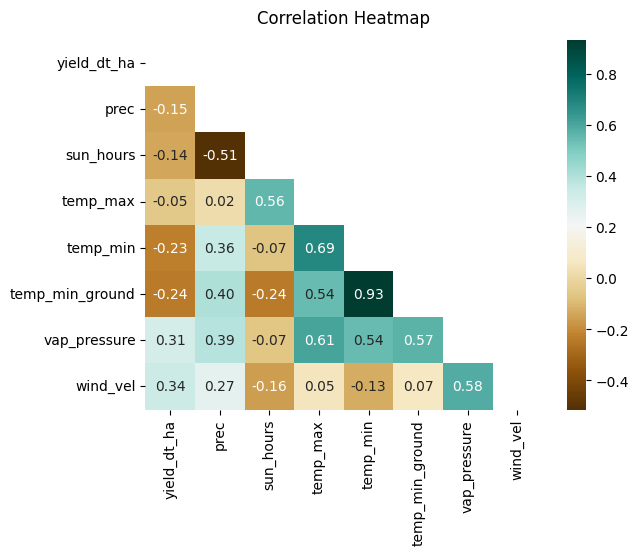

In [2]:
# --------------------------------------------------------------
# Plot Correlation Matrix Heatmap
# --------------------------------------------------------------
# Triangle Correlation Heatmap
correlation_df = data_df.drop("year", axis=1).corr()
mask = np.triu(np.ones_like(correlation_df))
p = sns.heatmap(correlation_df, mask=mask, annot=True, cmap="BrBG", fmt=".2f")
p.set_title("Correlation Heatmap", fontdict={"fontsize": 12}, pad=12)

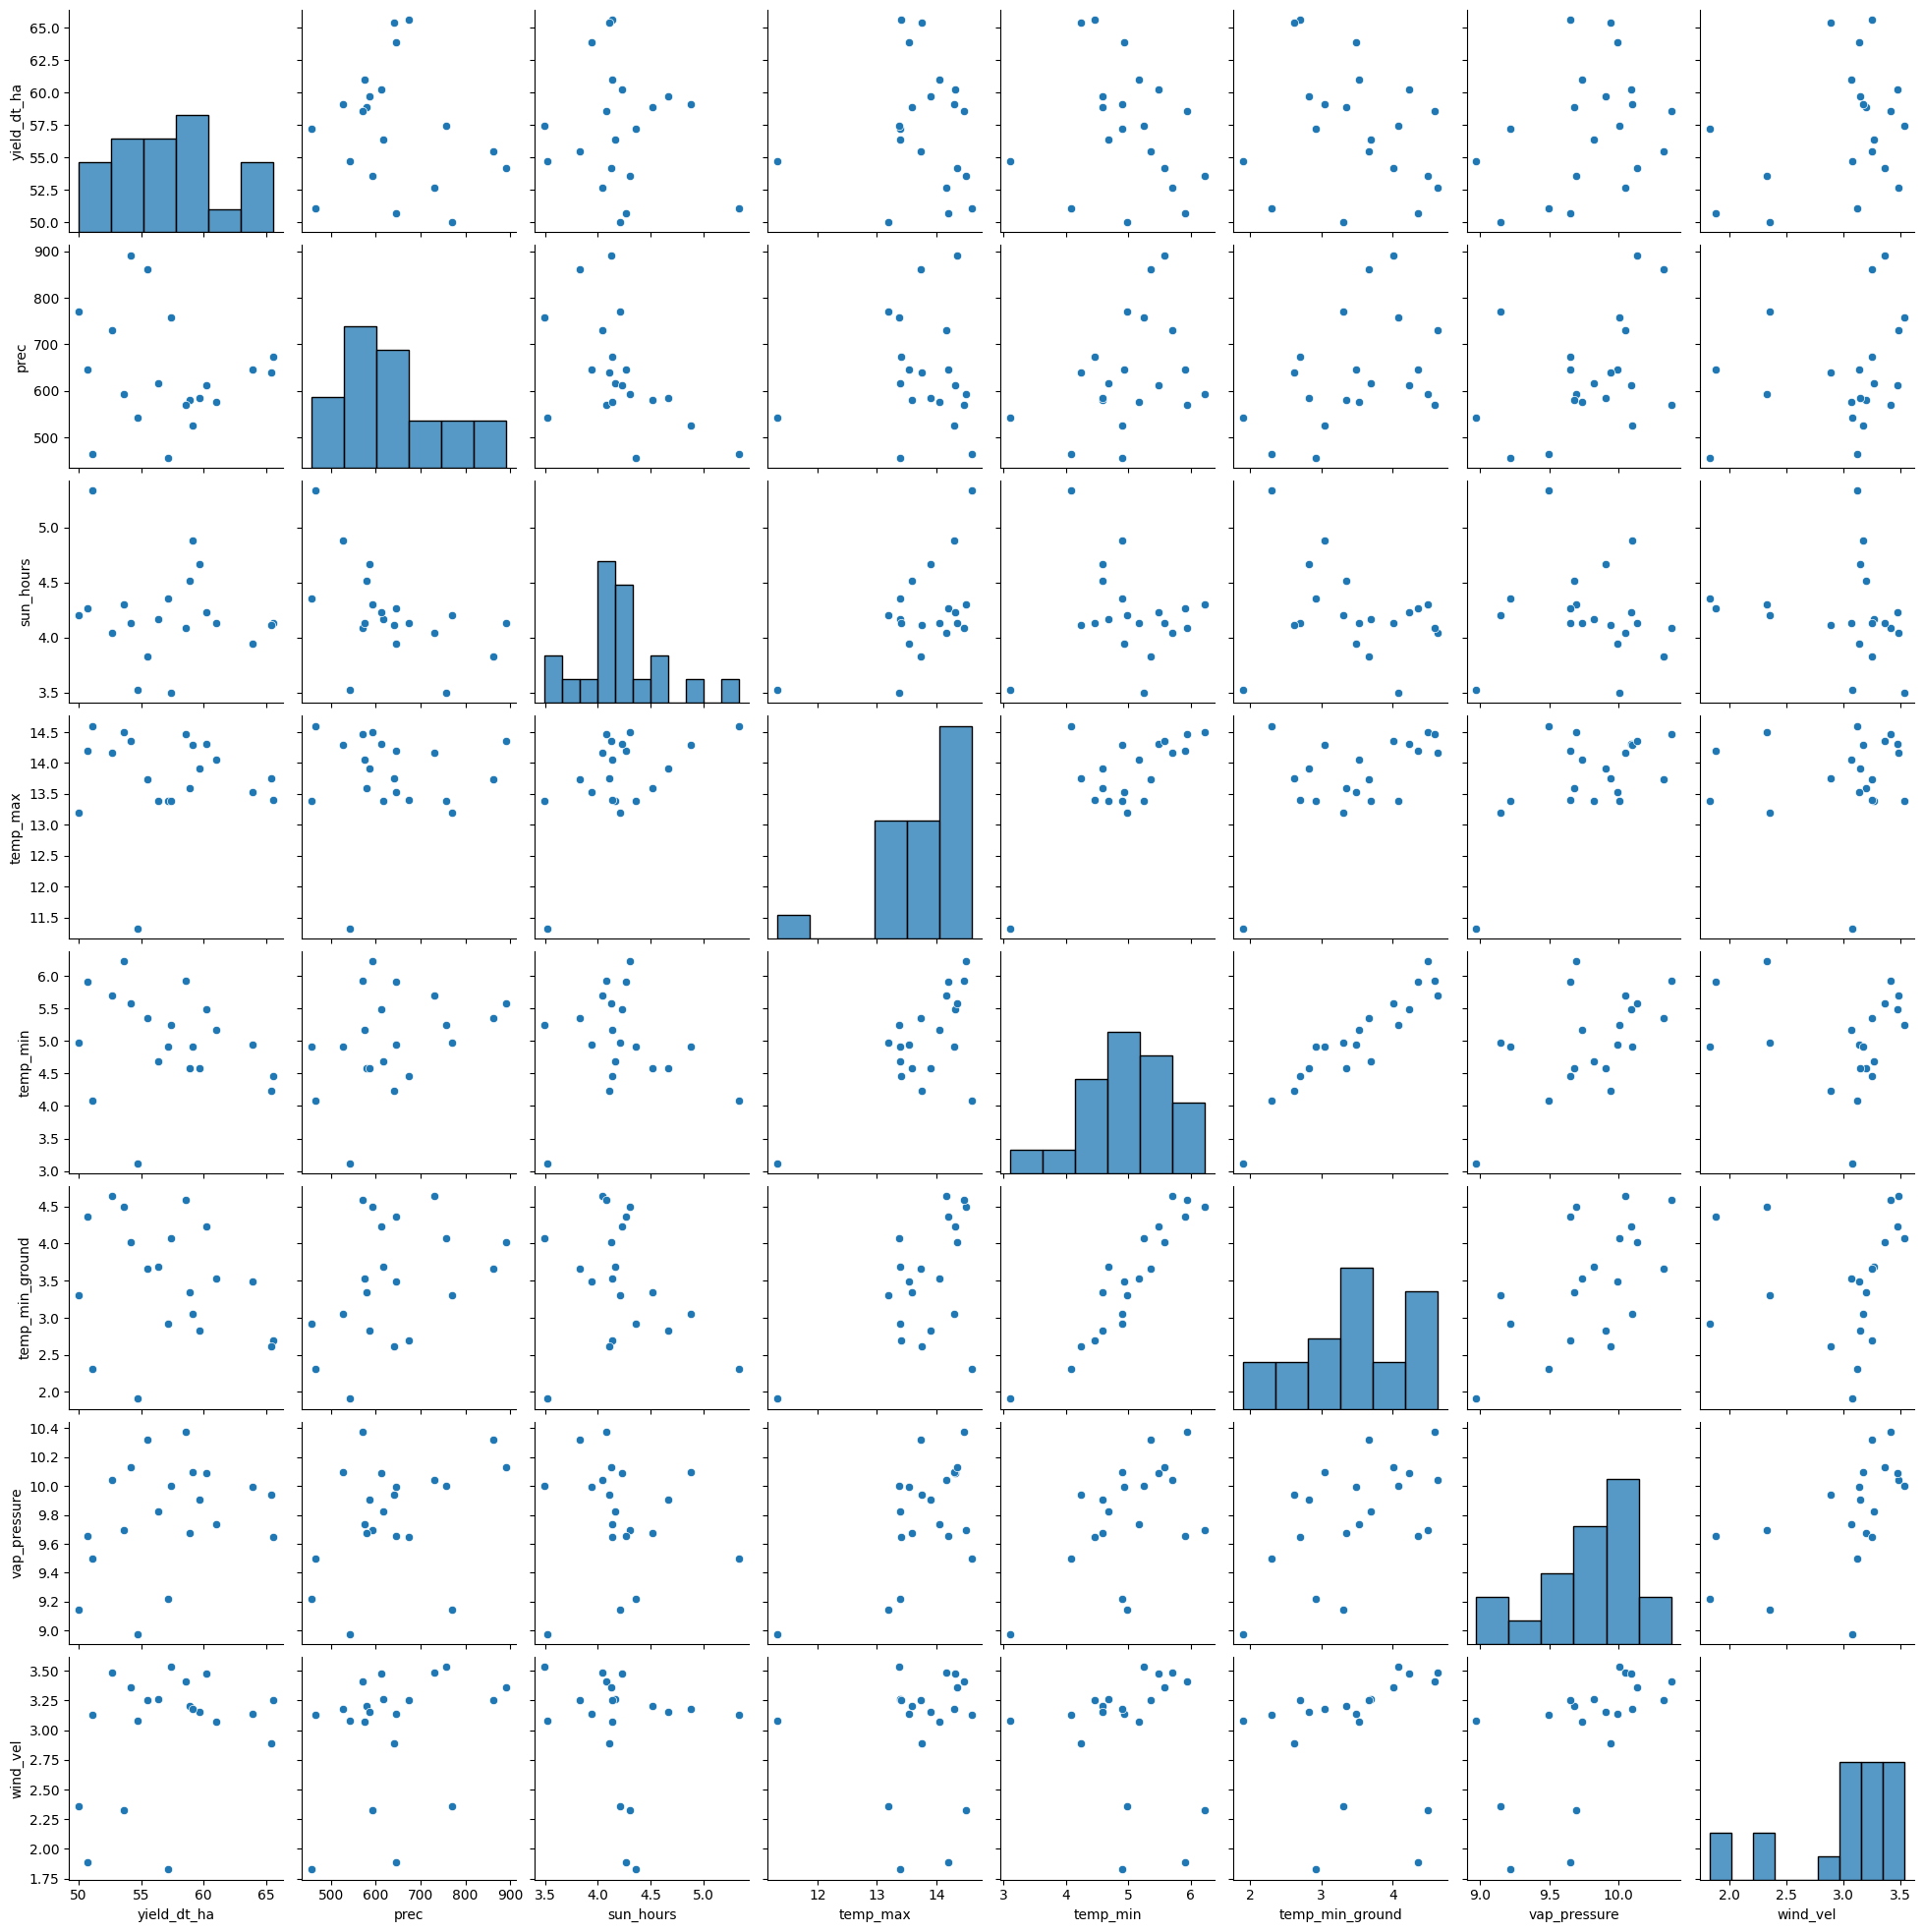

In [3]:
sns.pairplot(data_df.drop("year", axis=1))

## First Approach: Forward Selection

First Loop:
The variable with the lowest p-value is vap_pressure. Additionally, it has the lowest RMSE and is the only one with a positive R-squared.

Second Loop:
We proceed by selecting wind_vel as the first variable and attempt to add a second variable. The best performing second variable is temp_min_ground. The table shows that it has the lowest p-value, and it increases the R-squared and reduces the RMSE when added to the model.

Third Loop:
Once vap_pressure and temp_min_ground are part of the model, none of the remaining variables show a significant p-value. sun_hours has the lowest p-value among them and would slightly improve the model's prediction ability, as indicated by a lower RMSE and higher R-squared.

So far I would select a two-variable model with vap_pressure and temp_min_ground. I would avoid selecting a third variable.



In [4]:
def evaluate_new_predictors(data_df, target, predictors, selected_vars=[]):
    # Initialize list to store results
    results = []

    # Loop over each predictor
    for candidate in predictors:
        if candidate not in selected_vars:
            # Create model with selected variables and the candidate variable
            model_vars = selected_vars + [candidate]
            X = data_df[model_vars]
            y = data_df[target]
            
            model = sm.OLS(y, X).fit()
            model.summary()
            y_hat = model.predict(X)
            
            # Collect parameters and p-values
            params = model.params
            pvalues = model.pvalues
            # Calculate R-squared and RMSE
            # r_squared = model.rsquared
            r_squared = r2_score(y_true=y, y_pred=y_hat)
            rmse = np.sqrt(mean_squared_error(y, y_hat))
            result = {
                'predictor': candidate,
                'params': params[candidate],
                'pvalues': pvalues[candidate],
                'r_squared': r_squared,
                'rmse': rmse,
            }
            # Include already selected variables' parameters and p-values
            for var in selected_vars:
                result[f'param_{var}'] = params[var]
                result[f'pvalue_{var}'] = pvalues[var]
            
            results.append(result)

            ggplot(data_df)+ geom_point(aes(y=target, x=candidate))
            
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    results_df.sort_values("pvalues", ascending=True, inplace=True)
    return results_df

# First Loop
# Define the target and predictor variables
target = 'yield_dt_ha'
predictors = ['prec', 'sun_hours', 'temp_max', 'temp_min', 'temp_min_ground', 'vap_pressure', 'wind_vel']
selected_vars = []  # Start with no selected variables or add any pre-selected variables here

# Evaluate new predictors
results_df = evaluate_new_predictors(data_df, target, predictors, selected_vars)
display(results_df)

,predictor,params,pvalues,r_squared,rmse
5,vap_pressure,5.844583,8.514359e-23,0.069912,4.334430
2,temp_max,4.146627,7.986541e-21,-0.499864,5.504223
1,sun_hours,13.448139,3.460720e-18,-1.840789,7.575120
6,wind_vel,18.597862,6.580483e-17,-2.872106,8.843897
3,temp_min,11.190841,8.450212e-16,-4.063938,10.113797
0,prec,0.086997,1.172065e-14,-5.675703,11.612308
4,temp_min_ground,15.611866,4.561910e-13,-8.805526,14.073609


In [5]:
# Second Loop
target = 'yield_dt_ha'
predictors = ['prec', 'sun_hours', 'temp_max', 'temp_min', 'temp_min_ground', 'wind_vel', ]
selected_vars = ['vap_pressure']  # Start with no selected variables or add any pre-selected variables here

# Evaluate new predictors
results_df = evaluate_new_predictors(data_df, target, predictors, selected_vars)
display(results_df)

,predictor,params,pvalues,r_squared,rmse,param_vap_pressure,pvalue_vap_pressure
4,temp_min_ground,-3.380638,0.012461,0.348731,3.627022,7.051120,4.811385e-12
3,temp_min,-3.564151,0.018654,0.321806,3.701238,7.667740,2.741481e-09
0,prec,-0.013475,0.153098,0.172240,4.089049,6.721534,1.363528e-09
2,temp_max,-2.205492,0.215697,0.147865,4.148818,8.945086,1.642493e-03
5,wind_vel,1.124126,0.633856,0.081887,4.306437,5.498137,4.955129e-07
1,sun_hours,-0.394569,0.864910,0.071449,4.330848,6.014103,9.408094e-06


In [6]:
# Third Loop
target = 'yield_dt_ha'
predictors = ['prec', 'sun_hours', 'temp_max', 'temp_min', 'vap_pressure', ]
selected_vars = ['vap_pressure', "temp_min_ground"]  # Start with no selected variables or add any pre-selected variables here

# Evaluate new predictors
results_df = evaluate_new_predictors(data_df, target, predictors, selected_vars)
display(results_df)

,predictor,params,pvalues,r_squared,rmse,param_vap_pressure,pvalue_vap_pressure,param_temp_min_ground,pvalue_temp_min_ground
1,sun_hours,-2.870352,0.173146,0.417953,3.428855,8.535500,7.859628e-07,-4.084424,0.005463
2,temp_max,-1.407824,0.374171,0.379152,3.541298,8.946573,5.860925e-04,-3.146172,0.022182
0,prec,-0.007560,0.382547,0.378127,3.544223,7.421902,7.757306e-10,-3.040956,0.029738
3,temp_min,-0.891263,0.792437,0.351457,3.619422,7.246247,1.795352e-07,-2.649956,0.390281


**Test for Multicollinearity**

The test in the two variables model shows that there is a high multicollinearity. This is a problem, as it can cause significant issues in the regression model, such as:

* Unstable Coefficients: Coefficients may vary greatly with small changes in the model.

* Reduced Interpretability: Difficulty in determining the individual effect of each predictor.

* Inflated Standard Errors: Making it harder to detect significant predictors.

The conclusion is that the data is limited for fitting an statistical model. The reasons are:

* Low Number of Observations: The dataset contains only 19 observations, which is a small sample size for achieving statistical significance in parameter testing.

* Temporal Aggregation: The weather variables are aggregated annually, which might weaken the relationship between the variables and barley yields. Aggregating the data over the cropping season, or even better, during specific stages of the crop cycle, could provide a more accurate model.

* Geographic Aggregation: The lack of spatial granularity may affect the results. Aggregating variables specifically for areas where barley is planted could improve the model's accuracy.

A model with one variable is the only one statistically sound. That variable is `vap_pressure`. Nevertheless, the prediction ability of the model is low, with an R squared=0.06 and an RMSE=4.33



In [7]:
# Test for Multicollinearity

# Get the selected features
selected_features = ['temp_min', 'vap_pressure']
X_selected = data_df[selected_features]

# Add a constant term for the intercept
# X_selected_with_const = sm.add_constant(X_selected)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
vif_data


,feature,VIF
0,temp_min,63.806447
1,vap_pressure,63.806447


## Second Approach: Focus on Prediction Ability

From a statistical perspective, we aim to determine whether a parameter is significantly different from zero to ascertain if it genuinely influences yields. From a prediction standpoint, we focus on maximizing  prediction metrics, such as MSE, R² and RMSE. In this approach, we will select the set of parameters that optimize prediction performance using cross-validation techniques. While the individual parameters may not always be statistically significant, and we shouldn't make any claims about the individual effect of the parameters on the predicted variable. 

The cross-validation process splits the data into folds and evaluates the model's performance on each fold, ensuring that the selected predictors generalize well to unseen data.

Results show that the model performs similarly with 2 or 3 features. The 3 features have a larger standard deviation - that is the deviation of the scores in the different cross validation samples. That suggests that it will be better to use only 2 features. 

In [8]:
%%capture 
# https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

target = 'yield_dt_ha'
predictors = ['prec', 'sun_hours', 'temp_max', 'temp_min', 'temp_min_ground', 'vap_pressure', 'wind_vel']

y = data_df[target]
X = data_df[predictors]

# Initialize linear regression model
lr = LinearRegression()

# Forward selection with cross-validation
forward = SFS(lr, 
          k_features=7, 
          forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          verbose=0,
          cv=5)

sfs = forward.fit(X,y)

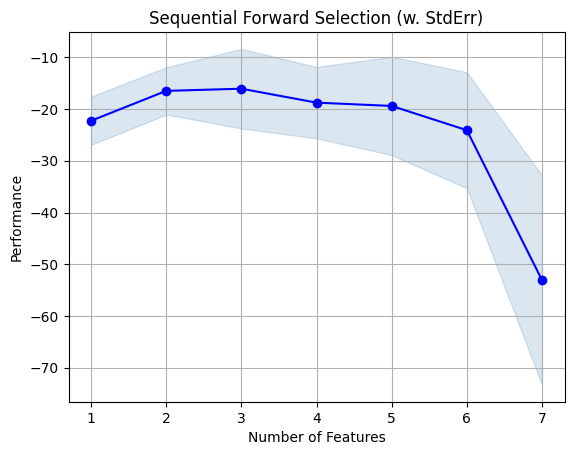

In [9]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

The selected two features are ['temp_min', 'vap_pressure']. 
The Obs. vs. Predicted plot shows the fit of the final model on the full dataset. The final perfomance metrics are an R-squared of 0.32 and an RMSE of 3.7. 

In [11]:
%%capture 

# Forward selection with cross-validation
forward = SFS(lr, 
          k_features=2, 
          forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          verbose=0,
          cv=5)

sfs = forward.fit(X,y)

feat_names = list(sfs.k_feature_names_)
print(feat_names)

# print(sfs.k_feature_idx_)

# Full Sample Performance --------------------------------
# X_selected = sm.add_constant(data_df[feat_names])
X_selected = data_df[feat_names]
regressor_OLS = sm.OLS(endog=y,exog=X_selected).fit()
regressor_OLS.summary()

y_hat = regressor_OLS.predict(X_selected)
r_squared = round(r2_score(y_true=y, y_pred=y_hat), 2)
rmse = round(np.sqrt(mean_squared_error(y, y_hat)),2)


In [12]:
print(f"R squared = {r_squared} - RMSE = {rmse}")

R squared = 0.32 - RMSE = 3.7


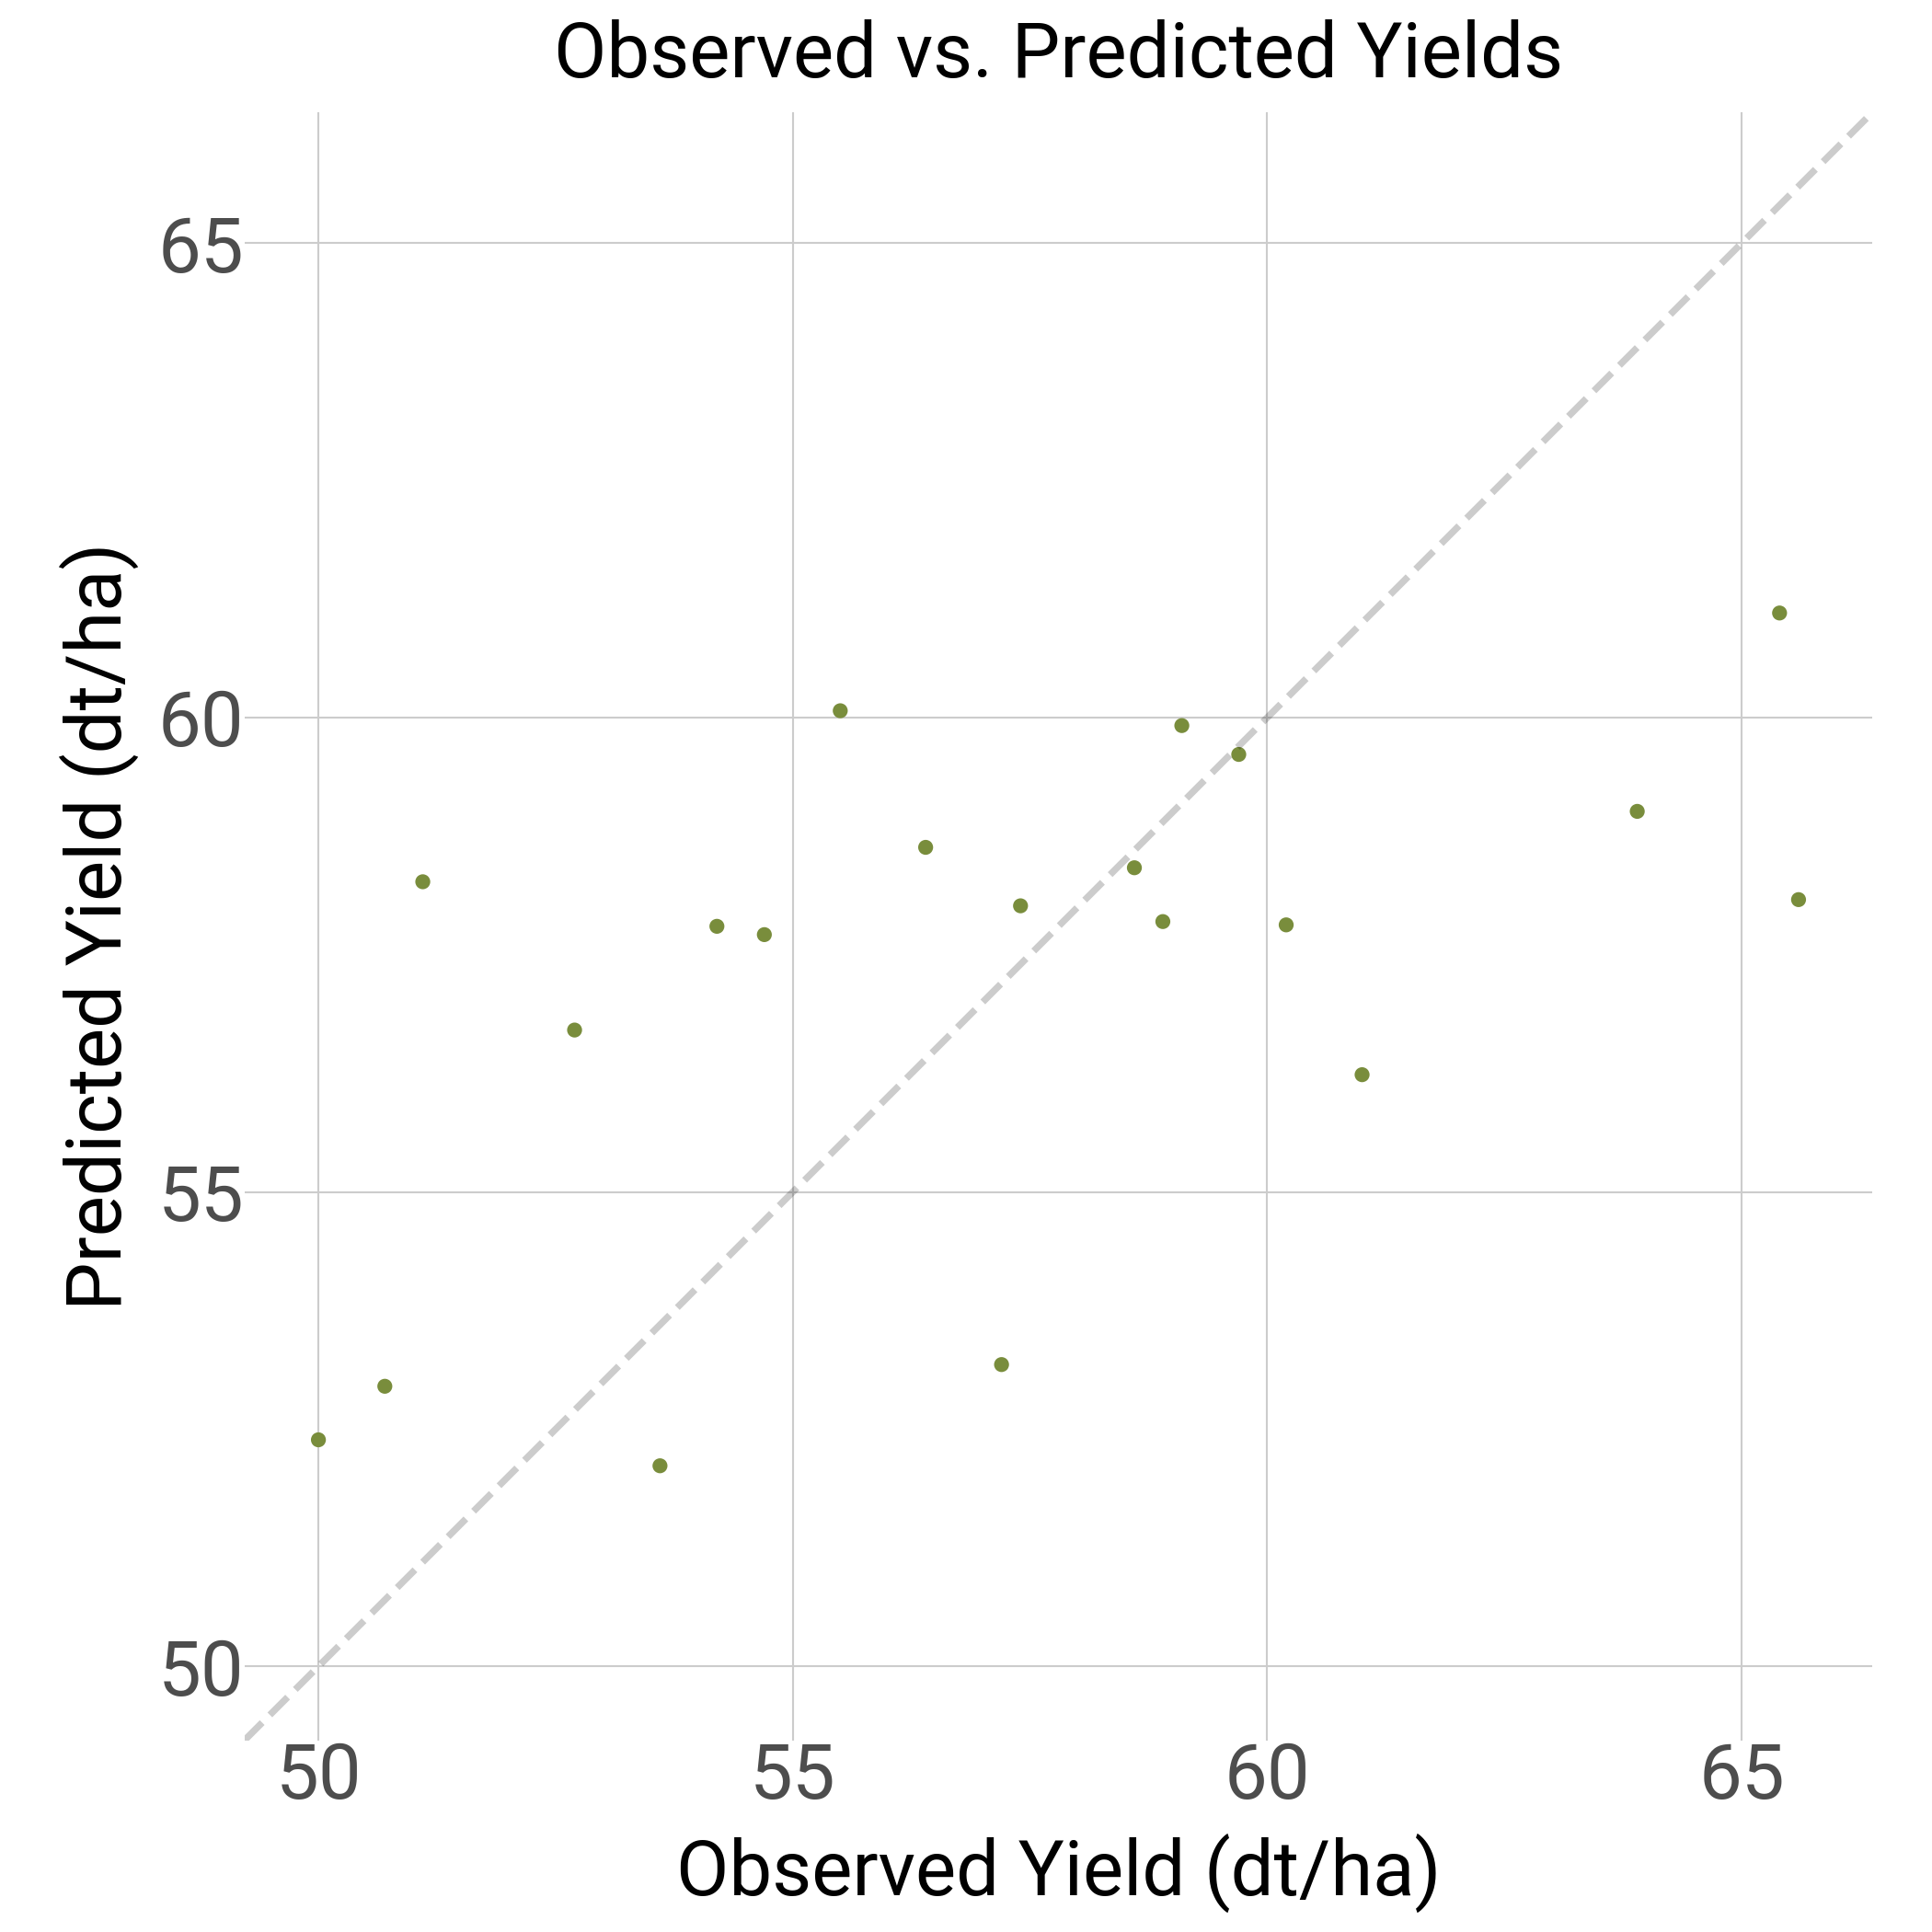

In [13]:
# Observed vs. Predicted Plot
model_vars = ["vap_pressure","temp_min"]
X = data_df[model_vars]
y = data_df[target]

model = sm.OLS(y, X).fit()
data_df["y_hat"] = model.predict(X)

(g, corr_val, r2_val, rmse_val) = plot_obs_vs_pred(data_df, x_var=target, y_var="y_hat")

g =(
    g + labs(
            x="Observed Yield (dt/ha)",
            y="Predicted Yield (dt/ha)",
            # color="",
            title="Observed vs. Predicted Yields",
        ) 
        # + theme(
        #     figure_size=[2, 2],
        #     )
)
display(g)

**Conclusion**

Two approaches for variable selection were tested: one focusing on statistical significance, and another focusing on accuracy in unseen data. The dataset is limited for statistical analysis due to the low number of observations and high correlation among the predictors. The statistical approach shows that we can only build a prediction model with one variable that is statistically significant. Adding a second variable introduces the issue of multicollinearity.

If the objective is to make predictions for a new, unseen year, I would use the second approach, which selected temp_min and vap_pressure, as they maximized performance on unseen data. In this approach, we should avoid making statistical claims about the effect of each factor due to multicollinearity. The goal is solely to make accurate predictions on unseen data.

Suggestions for Improving Model Performance:

* Perform PCA: Perform Principal Component Analysis (PCA) to reduce the dimensionality of the predictors and use the principal components for regression. This helps mitigate multicollinearity and retains most of the variability in the data.

* Increase Number of Observations: Increasing the number of observations and improving temporal and spatial granularity can provide a more robust dataset for analysis. Aggregating data over specific stages of the crop cycle or specific geographic areas where barley is planted can improve model accuracy.

* Crop Modeling: Crop modeling can be used to generate additional variables, aggregated for particular stages of the crop cycle, potentially increasing model performance. It can also be used to expand the dataset and simulate how yield would change under different conditions.

By addressing these areas, we can build a more accurate and robust model for predicting barley yield.
